In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 불러오기
df = pd.read_csv('NVspinData_None_-1_230807.csv')

# 데이터셋 분리: train_set 8 : test_set 2
train_df, test_df = train_test_split(df, shuffle=True, test_size=0.2)
# train_set을 다시 8:2로 나눠서 train_set과 validation_set을 만듦
train_df, val_df = train_test_split(train_df, shuffle=True, test_size=0.2)
# random_state=42

# 모든 시퀀스의 길이 중에서 최대 길이를 구하기
all_sequences = [eval(seq) for seq in df['combination'].values]
max_seq_length = max([len(seq) for seq in all_sequences])

# 각 데이터셋에서 theta, phi, sequence 추출하고 reshape 적용
theta_train = train_df['Theta'].values.reshape(-1, 1)
phi_train = train_df['Phi'].values.reshape(-1, 1)
sequence_train = pad_sequences(train_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_val = val_df['Theta'].values.reshape(-1, 1)
phi_val = val_df['Phi'].values.reshape(-1, 1)
sequence_val = pad_sequences(val_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_test = test_df['Theta'].values.reshape(-1, 1)
phi_test = test_df['Phi'].values.reshape(-1, 1)
sequence_test = pad_sequences(test_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

# theta_train[:5]

In [2]:

# 모델 정의
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')

# theta와 phi를 Concatenate
merged = Concatenate()([theta_input, phi_input])

# 시퀀스를 예측하기 위한 SimpleRNN 레이어
repeated_vector = RepeatVector(max_seq_length)(merged)  # max_sequence_length는 시퀀스의 최대 길이

rnn_layer = SimpleRNN(64, return_sequences=True, name='rnn_layer')(repeated_vector)

output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer)

model = Model(inputs=[theta_input, phi_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit([theta_train, phi_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([theta_val, phi_val], np.expand_dims(sequence_val, -1)), epochs=50, batch_size=64)

# 검증
loss, accuracy = model.evaluate([theta_test, phi_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/50
124/124 [==============================] - 2s 8ms/step - loss: 1.0404 - accuracy: 0.5614 - val_loss: 0.8345 - val_accuracy: 0.6035
Epoch 2/50
124/124 [==============================] - 1s 6ms/step - loss: 0.8497 - accuracy: 0.5952 - val_loss: 0.8200 - val_accuracy: 0.6168
Epoch 3/50
124/124 [==============================] - 1s 6ms/step - loss: 0.8315 - accuracy: 0.6034 - val_loss: 0.8289 - val_accuracy: 0.6113
Epoch 4/50
124/124 [==============================] - 1s 6ms/step - loss: 0.8231 - accuracy: 0.6105 - val_loss: 0.8015 - val_accuracy: 0.6147
Epoch 5/50
124/124 [==============================] - 1s 6ms/step - loss: 0.7254 - accuracy: 0.6860 - val_loss: 0.5398 - val_accuracy: 0.8026
Epoch 6/50
124/124 [==============================] - 1s 6ms/step - loss: 0.4655 - accuracy: 0.8302 - val_loss: 0.4100 - val_accuracy: 0.8576
Epoch 7/50
124/124 [==============================] - 1s 6ms/step - loss: 0.4070 - accuracy: 0.8539 - val_loss: 0.3875 - val_accuracy: 0.8679
Epoch 

In [8]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과 출력
for i in range(10):
    print(f"Sample {i + 1}:")
    print("Theta    :", theta_samples[i])
    print("Phi      :", phi_samples[i])
    print("Actual   :", sequence_samples[i])
    print("Predicted:", predicted_sequences[i])
    print("----------")


1/1 [==============================] - 0s 27ms/step
Sample 1:
Theta    : [2.89899543]
Phi      : [1.69727917]
Actual   : [0 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 2 4 4 1]
Predicted: [0 0 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 4 1]
----------
Sample 2:
Theta    : [2.00972093]
Phi      : [5.93593432]
Actual   : [0 0 0 0 0 0 0 0 0 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 4 4 4 3 1]
Predicted: [0 0 0 0 0 0 0 0 0 4 4 1 1 3 3 2 2 4 1 1 1 3 3 2 2 4 4 1 3 3 3 2 3 0 0]
----------
Sample 3:
Theta    : [0.64568926]
Phi      : [0.89827853]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 2 4 1 1 3]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 2 2 4 4 3 1]
----------
Sample 4:
Theta    : [0.48868434]
Phi      : [4.0858048]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 2 2]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 4 4 1 0 3 3 2 4]
----------
Sample 5:

In [9]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame({
    'Theta': theta_samples.ravel(),
    'Phi': phi_samples.ravel(),
    'Actual Sequence': [list(seq) for seq in sequence_samples],
    'Predicted Sequence': [list(seq) for seq in predicted_sequences]
})

# 결과를 CSV 파일로 저장
df_results.to_csv('rnn_results.csv', index=False)

print("Results saved to rnn_results.csv")


1/1 [==============================] - 0s 20ms/step
Results saved to rnn_results.csv


In [10]:
print(type(theta_train), theta_train.shape)
print(type(phi_train), phi_train.shape)
print(type(sequence_train), len(sequence_train))
print(type(theta_val), theta_val.shape)
print(type(phi_val), phi_val.shape)
print(type(sequence_val), len(sequence_val))

<class 'numpy.ndarray'> (7904, 1)
<class 'numpy.ndarray'> (7904, 1)
<class 'numpy.ndarray'> 7904
<class 'numpy.ndarray'> (1976, 1)
<class 'numpy.ndarray'> (1976, 1)
<class 'numpy.ndarray'> 1976


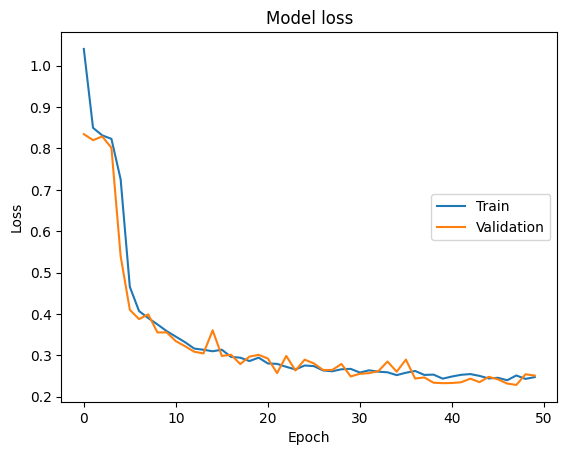

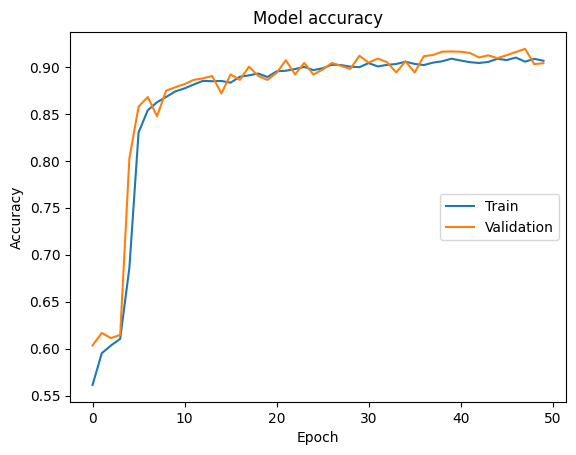

78/78 [==============================] - 0s 2ms/step - loss: 0.2423 - accuracy: 0.9052
Test Accuracy: 90.52
Test Loss: 24.23


In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='center right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='center right')
        plt.show()

def evaluate(model, theta, phi, sequence):
    loss, acc = model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, theta_test, phi_test, sequence_test)

In [23]:
# 새로운 theta와 phi 값 정의
new_theta = np.array([np.pi/2]).reshape(-1, 1)  # 예시 값
new_phi = np.array([np.pi]).reshape(-1, 1)    # 예시 값

# 모델로 예측
predicted_sequence = model.predict([new_theta, new_phi])

# 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)
print(predicted_sequence_indices[0])

1/1 [==============================] - 0s 26ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2]


In [24]:
# 모델 구조와 가중치 저장

model.save("230811_rnn_model.h5")

c:\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# from tensorflow.keras.models import load_model
# 모델 다시 불러오기

# loaded_model = load_model("230811_rnn_model.h5")

In [ ]:
# # JSON 포맷으로 모델 구조 저장
# model_json = model.to_json()
# with open("model_structure.json", "w") as json_file:
#     json_file.write(model_json)

# # 모델 구조를 JSON 파일에서 로드
# from tensorflow.keras.models import model_from_json

# with open("model_structure.json", "r") as json_file:
#     loaded_model_json = json_file.read()
# loaded_model = model_from_json(loaded_model_json)

In [ ]:
# # 모델의 가중치 저장
# model.save_weights("model_weights.h5")

# # 가중치를 새로운 모델에 로드 (이때, 모델의 아키텍처는 동일해야 합니다)
# new_model = create_model_function()  # 동일한 아키텍처를 갖는 새로운 모델 생성 함수
# new_model.load_weights("model_weights.h5")

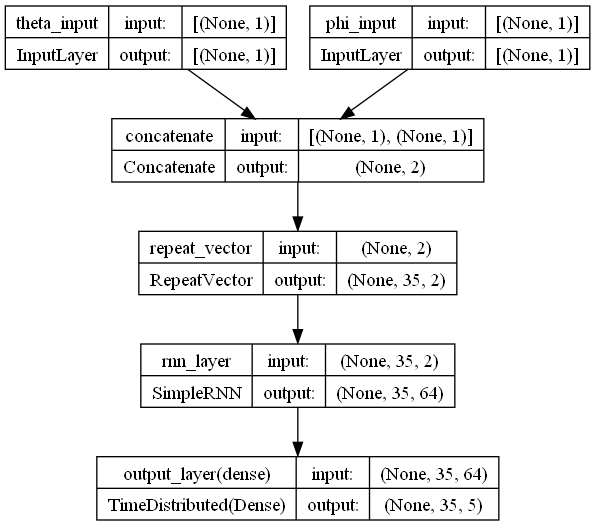

In [25]:
from tensorflow.keras.utils import plot_model

# 모델 구조 시각화
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


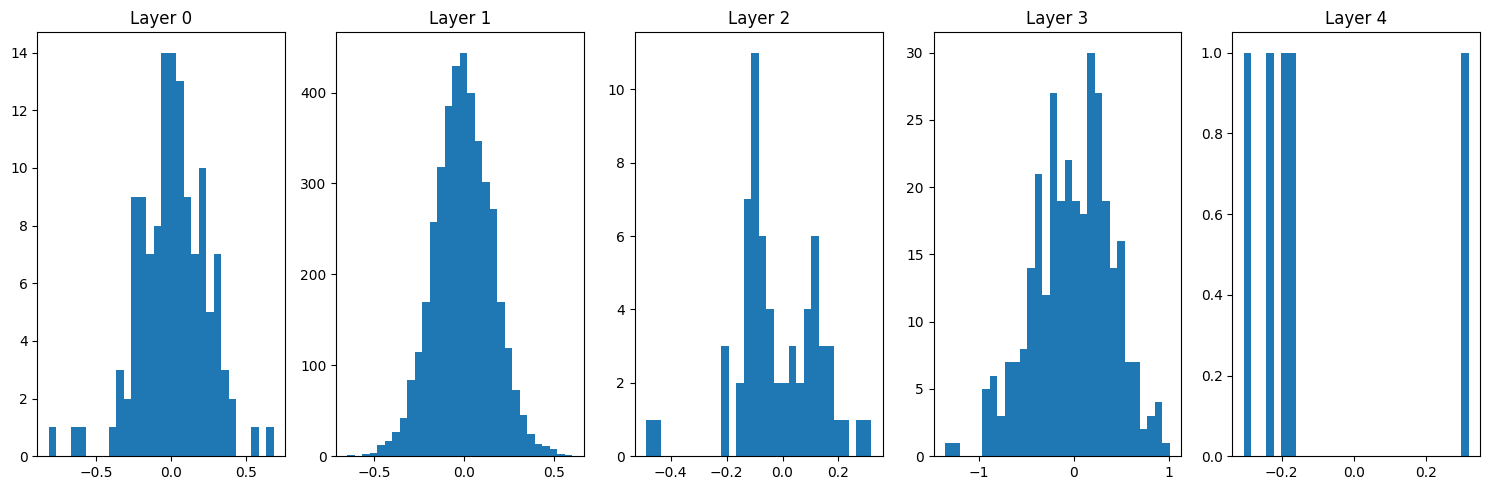

In [27]:
# import matplotlib.pyplot as plt

# # 모델의 가중치 가져오기
# weights = model.get_weights()

# n_weights = len(weights)

# plt.figure(figsize=(15, 5))
# for i, weight_matrix in enumerate(weights):
#     plt.subplot(1, n_weights, i+1)
#     plt.title(f"Layer {i}")
#     plt.hist(weight_matrix.flatten(), bins=30)
# plt.tight_layout()  # 이 부분은 그림들이 겹치지 않게 조절해 줍니다.
# plt.show()


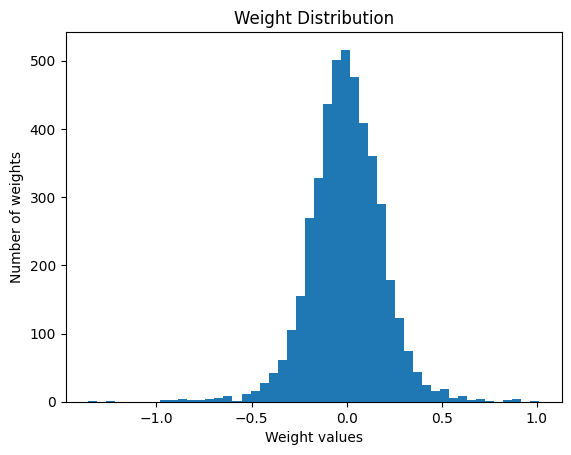

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 모델의 가중치 불러오기
weights = model.get_weights()

# 모든 가중치를 하나의 리스트로 합치기
all_weights = np.hstack([w.flatten() for w in weights if len(w.shape) > 1])

# 히스토그램 그리기
plt.hist(all_weights, bins=50)
plt.title("Weight Distribution")
plt.xlabel("Weight values")
plt.ylabel("Number of weights")

# PNG 파일로 저장
plt.savefig('weight_histogram.png')

# 그래프 표시
plt.show()


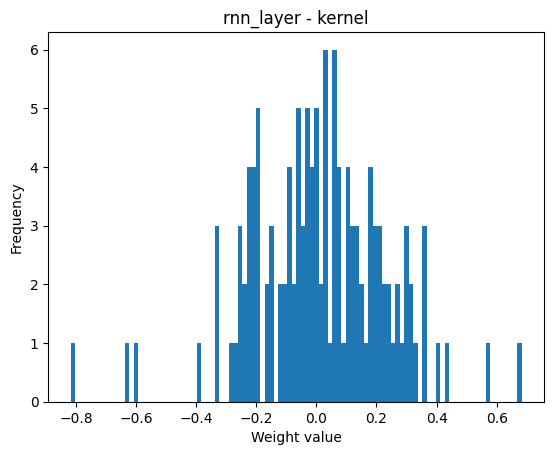

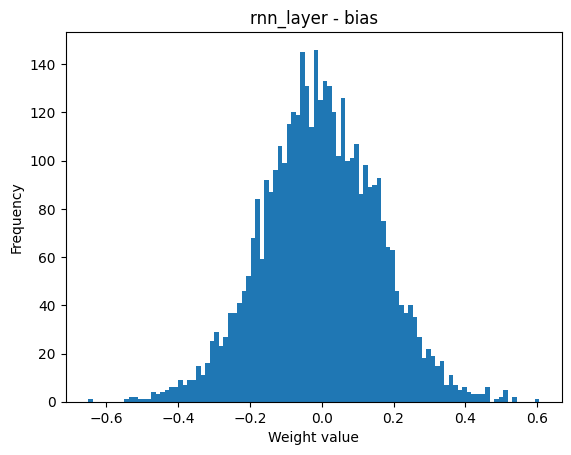

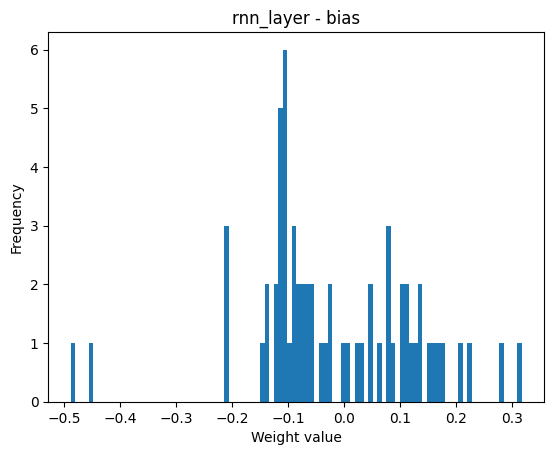

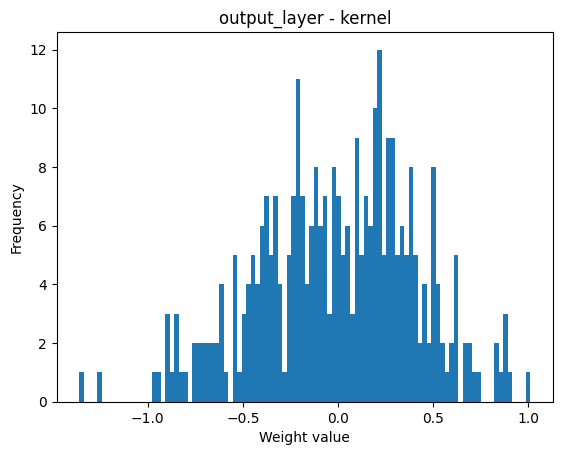

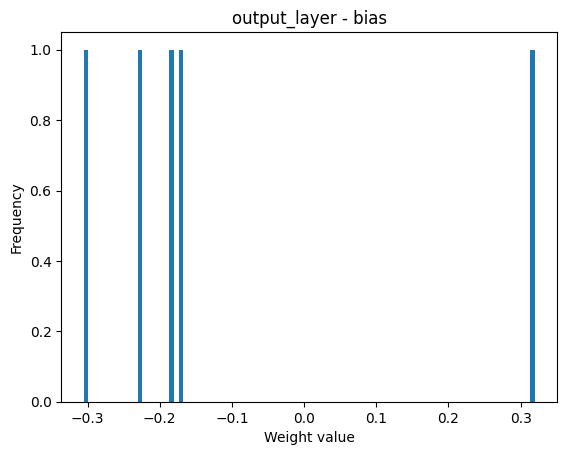

In [31]:
import os
import matplotlib.pyplot as plt

# 모델에서 모든 층 가져오기
layers = model.layers

# 저장할 메인 디렉토리 생성
if not os.path.exists('weights_histograms'):
    os.makedirs('weights_histograms')

# 각 층의 가중치에 대한 히스토그램 그리기
for layer in layers:
    weights = layer.get_weights()
    if weights:  # 가중치가 있는 층만 고려
        layer_name = layer.name
        layer_dir = os.path.join('weights_histograms', layer_name)
        
        # 각 층에 대한 서브디렉토리 생성
        if not os.path.exists(layer_dir):
            os.makedirs(layer_dir)
        
        # 해당 층의 모든 가중치 배열에 대한 히스토그램 생성
        for idx, weight_array in enumerate(weights):
            weight_type = 'kernel' if idx == 0 else 'bias'  # 보통 idx 0은 kernel, 1은 bias
            
            plt.hist(weight_array.flatten(), bins=100)
            plt.title(f'{layer_name} - {weight_type}')
            plt.xlabel('Weight value')
            plt.ylabel('Frequency')
            
            # 히스토그램 PNG로 저장
            filename = os.path.join(layer_dir, f'{weight_type}.png')
            plt.savefig(filename)
            
            # 히스토그램 표시 (선택사항)
            plt.show()
            
            # 현재 그래프를 닫음 (다음 그래프를 위해)
            plt.close()
